In [47]:
import os
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tools
import plotly.graph_objs as go
import plotly.figure_factory as ff
init_notebook_mode(connected=True)

In [52]:
def merge_csv(partition, gpus, num_nodes):
    benchmark_dir = "{}_gpus_{}_trials".format(gpus, partition)
    glob_pattern = os.path.join(benchmark_dir, "*.csv")
    csv_files = [f for f in glob.glob(glob_pattern)]
    combined_csv = pd.concat([pd.read_csv(f) for f in csv_files])
    # export to csv
    export_csv = "{node}_nodes_{gpus}_gpus_{partition}_benchmark.csv".format(
        node=num_nodes,
        partition=partition,
        gpus=gpus
    )
    combined_csv.to_csv(export_csv, index=False, encoding='utf-8-sig')


In [118]:
merge_csv(partition='t4', gpus=1, num_nodes=1)
merge_csv(partition='t4', gpus=2, num_nodes=2)
merge_csv(partition='t4', gpus=4, num_nodes=2)
merge_csv(partition='t4', gpus=8, num_nodes=4)

/Users/jiahuanglin/anaconda3/envs/data_vis/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [119]:
def add_column(df, output_col, input_cols, func):
    """Efficiently add a column to a DataFrame.
    This function is similar to Dataframe.apply() followed by adding
    the new series as a column in the dataframe.  Unfortunately, the
    DataFrame.apply() is slow, especially for large dataframes
    (possibly because a Series object is allocated and initialized
    with the values of the current row for each invocation of the function).
    The values of the new column are computed by calling ``func`` once
    for each row in the dataframe.  The arguments to ``func`` are the
    values of the columns specified by ``input_cols`` (in
    corresponding order).  The return value of ``func`` is set as the
    value of the new column for that row.  Note that you can use a
    lambda function with captured variables if necessary.
    Parameters
    ----------
    df : :py:class:`pandas.DataFrame`
        The dataframe to extend with a new column.  This dataframe is
        not modified.  Instead a new dataframe is returned.
    output_col : :py:class:`str`
        The name of the column to be added.
    input_cols : :py:class:`list` of :py:class:`str`
        The list of columns from ``df`` required to compute the new column.
    func : :py:class:`function`
        The function to be called once per row to compute the new column values.
    Returns
    -------
    :py:class:`pandas.DataFrame`
        A new dataframe based of ``df`` with the new column added.
    """

    # make a tuple of values of the requested input columns
    input_values = tuple(df[x].values for x in input_cols)

    # transpose to make a list of value tuples, one per row
    args = zip(*input_values)

    # evaluate the function to generate the values of the new column
    output_values = [func(*x) for x in args]

    # make a new dataframe with the new column added
    columns = {x: df[x].values for x in df.columns}
    columns[output_col] = output_values
    return pd.DataFrame(columns)

def add_columns(df, output_cols, input_cols, func, keep_index=False):
    """Efficiently add multiple columns to a DataFrame.
    This function is similar to ``add_column`` but it adds multiple
    columns instead of just one.  The values of the new columns are
    computed by calling ``func`` once for each row in the dataframe.
    The arguments to ``func`` are the values of the columns sepcified
    by ``input_cols`` (in corresponding order).  ``func`` should
    return a value for each of the output columns (in corresponding
    order).  Note that you can use a lambda function with captured
    variables if necessary.
    Parameters
    ----------
    Parameters
    ----------
    df : :py:class:`pandas.DataFrame`
        The dataframe to extend with a new column.  This dataframe is
        not modified.  Instead a new dataframe is returned.
    output_cols : :py:class:`list` of :py:class:`str`
        The names of the columns to be added.
    input_cols : :py:class:`list` of :py:class:`str`
        The list of columns from ``df`` required to compute the new columns.
    func : :py:class:`function`
        The function to be called once per row to compute the new column values.
    Returns
    -------
    :py:class:`pandas.DataFrame`
        A new dataframe based of ``df`` with the new columns added.
    """
    # handle the empty case
    if df.empty:
        new_df = pd.DataFrame(columns=df.columns)
        for output_col in output_cols:
            new_df[output_col] = []
        return new_df

    # make a tuple of values of the requested input columns
    input_values = tuple(map(lambda x: df[x].values, input_cols))

    # transpose to make a list of value tuples, one per row
    args = zip(*input_values)

    # evaluate the function to generate the values of the new column
    output_values = zip(*map(lambda x: func(*x), args))

    # make a new dataframe with the new column added
    columns = {x: df[x].values for x in df.columns}
    for output_col, output_value in zip(output_cols, output_values):
        columns[output_col] = output_value

    index = df.index if keep_index else None
    return pd.DataFrame(columns, index=index)

def concate_all_csv():
    dfs = []
    for name in glob.glob('*_benchmark.csv'):
        tags = name.split('_')
        num_nodes = int(tags[0])
        num_gpus = int(tags[2])
        gpu_type = tags[4]
        df = pd.read_csv(name).drop(["Unnamed: 0", "iteration"], axis=1)
        columns = {x: df[x].values for x in df.columns}
#         columns['num_nodes'] = num_nodes
        columns['num_gpus'] = num_gpus
        columns['gpu_type'] = gpu_type
        dfs.append(pd.DataFrame(columns))
        
    return pd.concat(dfs)

In [120]:
df = concate_all_csv()
df.to_csv("benchmark.csv")
df.sort_values('token_throughput')



/Users/jiahuanglin/anaconda3/envs/data_vis/lib/python3.7/site-packages/ipykernel_launcher.py:111: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,batch_size,elapsed_time,gpu_type,gradient_accumulation,log_interval,num_gpus,num_nodes,num_tokens,optimizer,precision,seq_length,token_throughput,weight_update_time,world_size
2,22.0,188.855958,t4,1,100.0,1,1,2816.0,adam,fp32,128.0,1491.083485,8.339325,1
0,32.0,90.700586,t4,1,100.0,1,1,4096.0,adam,fp16,128.0,4515.957600,8.389183,1
1,32.0,73.176968,t4,1,100.0,1,1,4096.0,fusedadam,fp16,128.0,5597.389597,0.926490,1
4,64.0,140.374618,t4,1,100.0,2,2,8192.0,lamb,fp16,128.0,5835.812871,2.116103,2
0,64.0,134.536037,t4,1,100.0,2,2,8192.0,fusedadam,fp16,128.0,6089.074835,1.047425,2
2,64.0,133.406436,t4,1,100.0,4,2,8192.0,fusedadam,fp16,128.0,6140.633255,1.058005,4
1,64.0,133.406436,t4,1,100.0,2,2,8192.0,fusedadam,fp16,128.0,6140.633255,1.058005,2
2,64.0,85.060842,t4,1,100.0,2,1,8192.0,fusedadam,fp16,128.0,9630.753475,0.998684,2
1,128.0,156.249566,t4,1,100.0,4,4,16384.0,fusedadam,fp16,128.0,10485.789120,1.079204,4
3,64.0,69.520652,t4,2,100.0,2,2,8192.0,fusedadam,fp16,128.0,11783.548816,1.034134,2


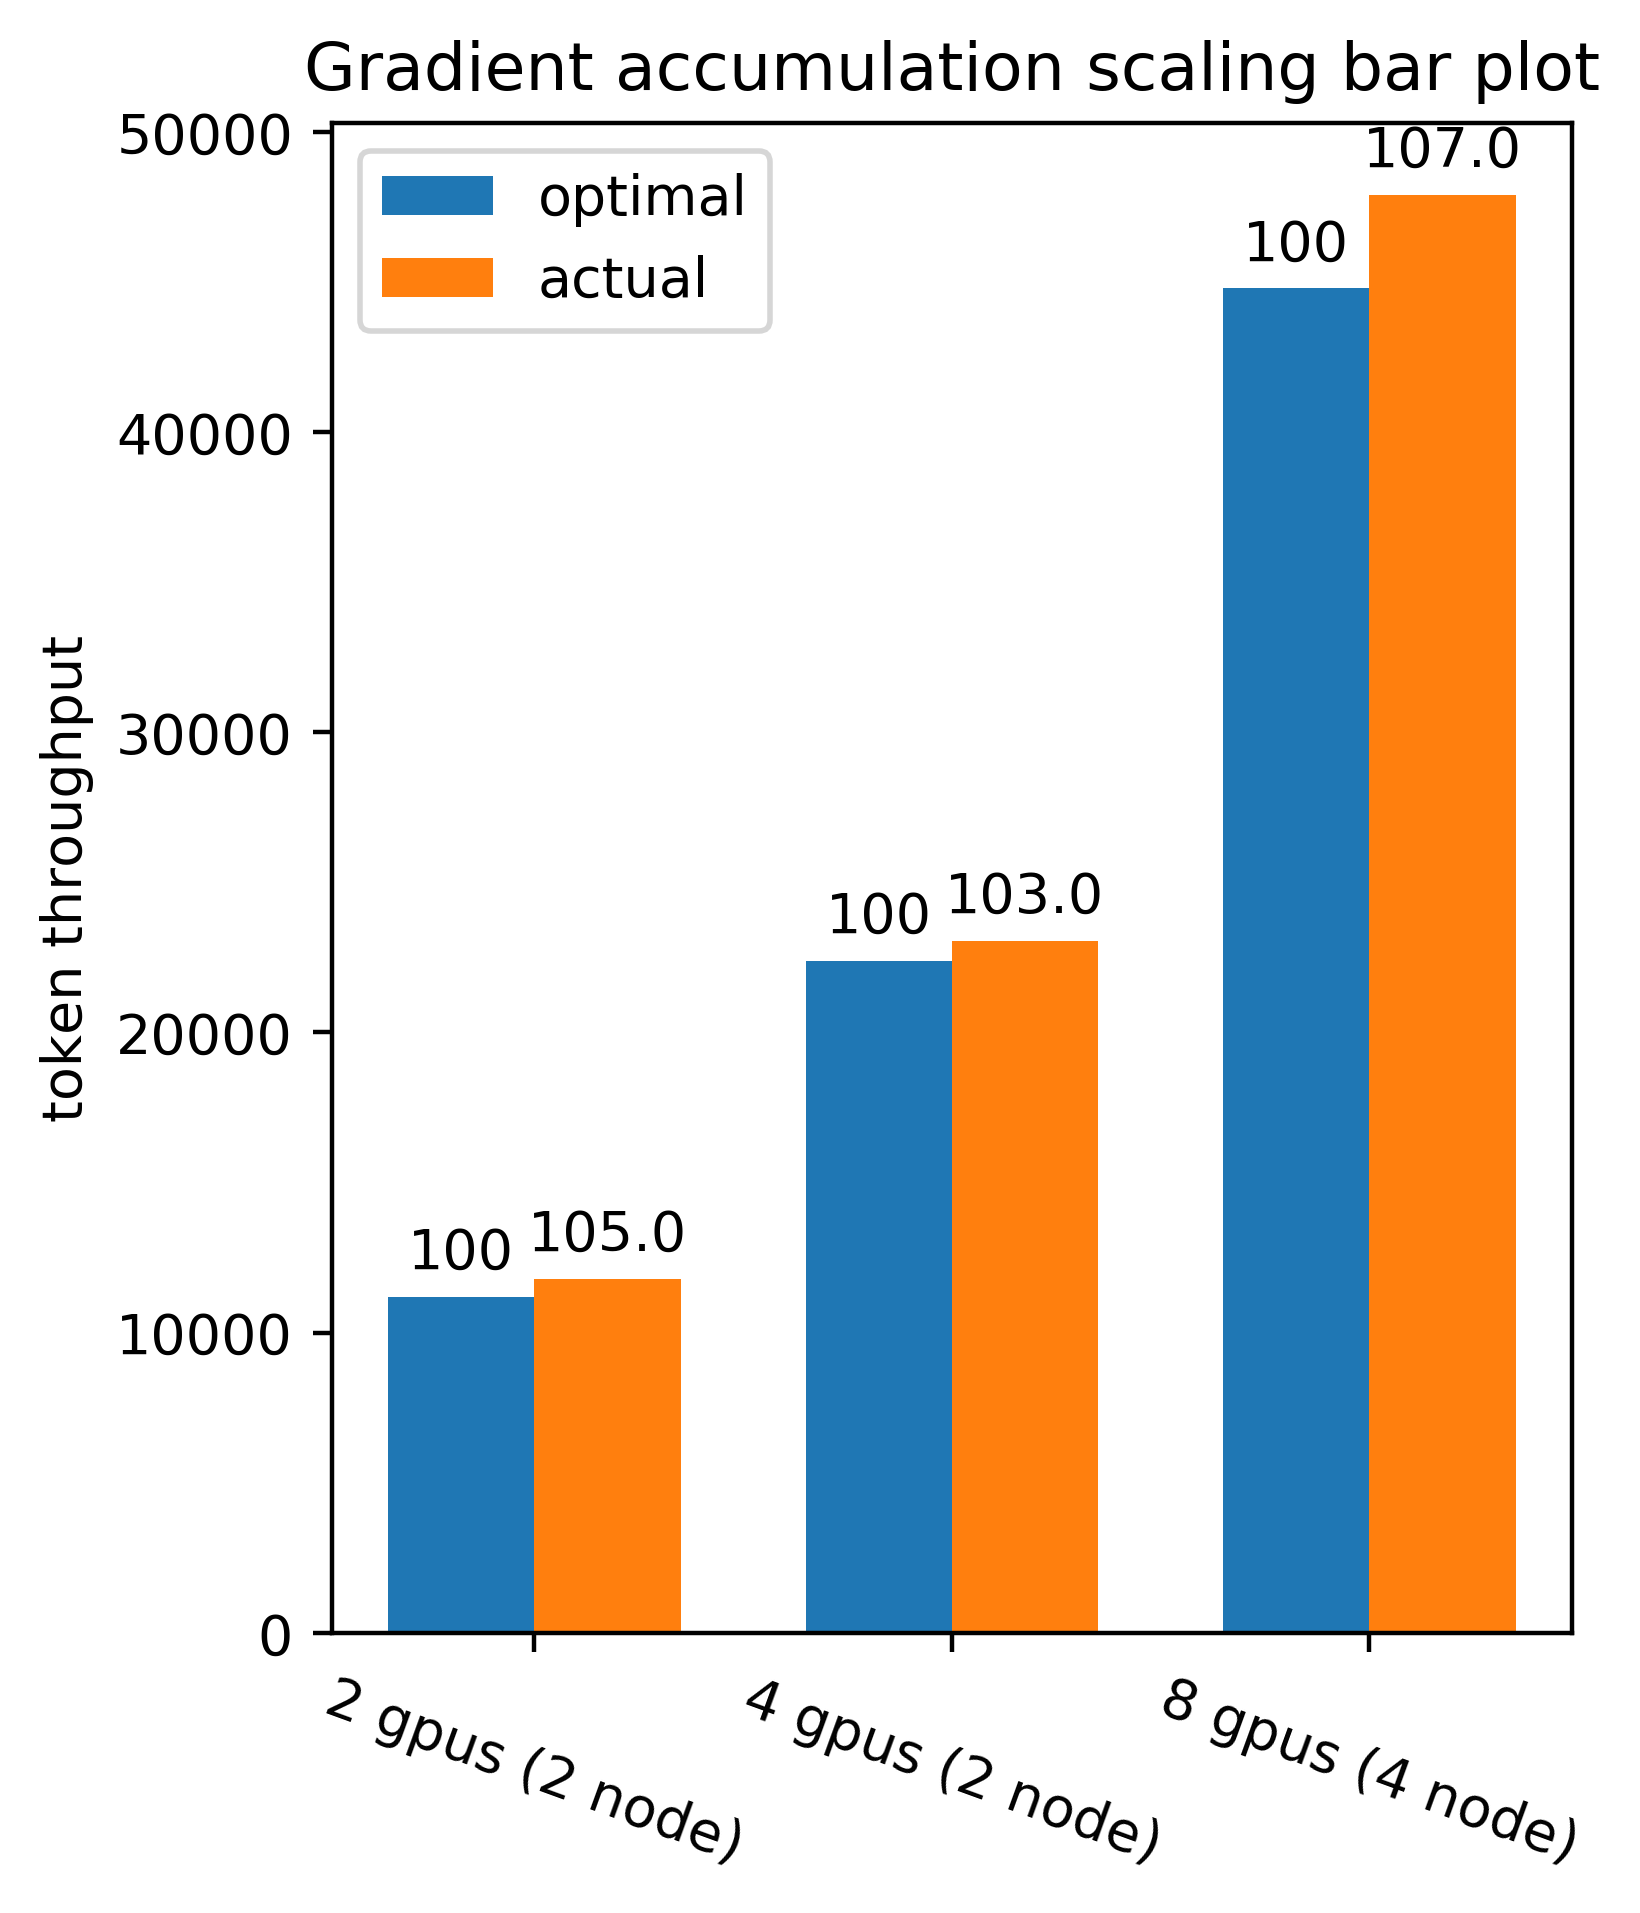

,batch_size,elapsed_time,gpu_type,gradient_accumulation,log_interval,num_gpus,num_nodes,num_tokens,optimizer,precision,seq_length,token_throughput,weight_update_time,world_size
0,256.0,68.404188,t4,2,100.0,8,4,32768.0,fusedadam,fp16,128.0,47903.499600,1.095594,8
0,128.0,71.104038,t4,2,100.0,4,2,16384.0,fusedadam,fp16,128.0,23042.291993,1.034493,4
3,64.0,69.520652,t4,2,100.0,2,2,8192.0,fusedadam,fp16,128.0,11783.548816,1.034134,2


In [146]:
def plot_gpu_accumulation_scaling(df):
    baseline = df[(df.num_gpus == 1) & 
                  (df.optimizer == "fusedadam")]
    
    baseline_throughput = baseline.token_throughput.values[0]
    
    grad_acc_df = df[df.gradient_accumulation > 1]
    
    num_gpus = [2, 4, 8]
    num_nodes = [2, 2, 4]
    actual = [11783.548816, 23042.291993, 47903.499600]
    optimal = [baseline_throughput * x for x in num_gpus]
    
    labels = ["2 gpus (2 node)", "4 gpus (2 node)", "8 gpus (4 node)"]
    width = 0.35
    x = np.arange(len(labels))
    
    fig, ax = plt.subplots(figsize=(4, 5), dpi=400, facecolor='w', edgecolor='k')
    
    # plot optimal throughput
    rects1 = ax.bar(x-width/2, optimal, width=width, label="optimal")
    
    # plot scaling
    rects2 = ax.bar(x+width/2, actual, width=width, label="actual")
    
    def autolabel(rects, data):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for i,rect in enumerate(rects):
            height = rect.get_height()
            ax.annotate('{}'.format(data[i]),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')    
    
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("token throughput")
    ax.set_title("Gradient accumulation scaling bar plot")
    plt.xticks(rotation=-20)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    autolabel(rects1, ["100", "100", "100"])
    autolabel(rects2, [round(x/baseline_throughput/num_gpus[i], 2) * 100 for i,x in enumerate(actual)])
    
    plt.show()
    
    return grad_acc_df
    
plot_gpu_accumulation_scaling(df)

In [107]:
def plot_two_gpu_scaling(df):
    baseline = df[(df.num_gpus == 1) & 
                  (df.optimizer == "fusedadam")]
    
    baseline_throughput = 5597.389597
    optimal = [2*baseline_throughput]*2
    actual = [9630.753475, 6089.074835]
    
    labels = ["one node", "two node"]
    width = 0.35
    x = np.arange(len(labels))
    
    fig, ax = plt.subplots(figsize=(4, 5), dpi=400, facecolor='w', edgecolor='k')
    
    # plot optimal throughput
    rects1 = ax.bar(x-width/2, optimal, width=width, label="optimal")
    
    # plot scaling
    rects2 = ax.bar(x+width/2, actual, width=width, label="actual")
    
    def autolabel(rects, data):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for i,rect in enumerate(rects):
            height = rect.get_height()
            ax.annotate('{}'.format(data[i]),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("token throughput")
    ax.set_title("Two GPU scaling bar plot")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    autolabel(rects1, ["100", "100"])
    autolabel(rects2, [ round(x/baseline_throughput/2, 2) * 100 for x in actual])
    
    plt.show()

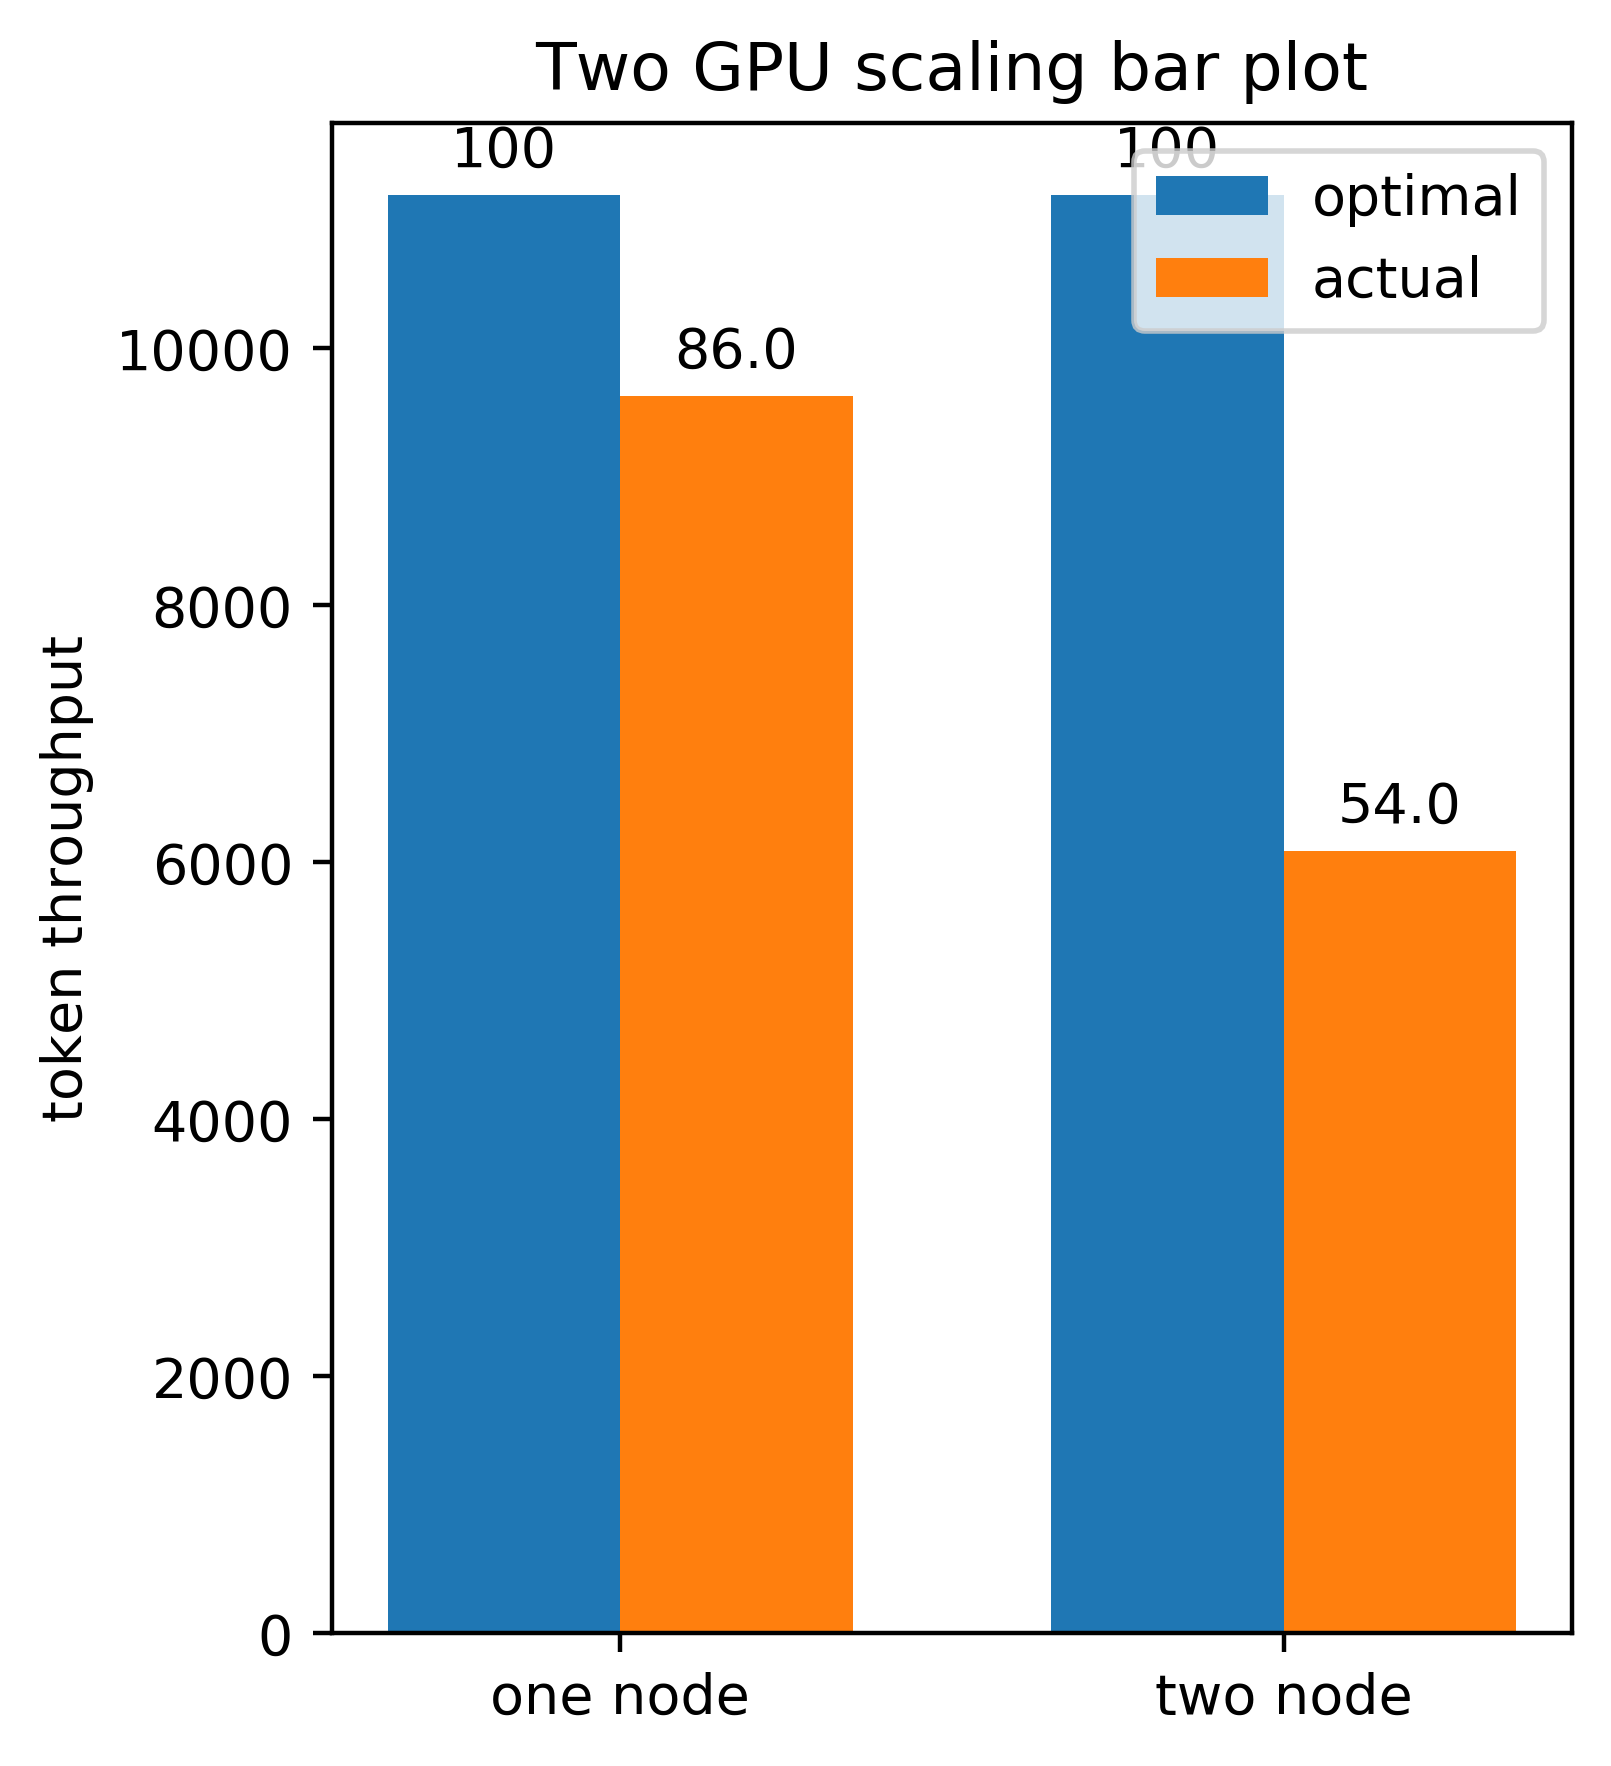

In [108]:
plot_two_gpu_scaling(df)

In [114]:
def plot_scaling_up(df):
    baseline = df[(df.num_gpus == 1) & 
                  (df.optimizer == "fusedadam")]
    
    baseline_throughput = 5597.389597
    optimal = [2*baseline_throughput, 4*baseline_throughput]
    actual = [6089.074835, 10485.789120]
    
    labels = ["2 nodes", "4 nodes"]
    width = 0.35
    x = np.arange(len(labels))
    
    fig, ax = plt.subplots(figsize=(4, 5), dpi=400, facecolor='w', edgecolor='k')
    
    # plot optimal throughput
    rects1 = ax.bar(x-width/2, optimal, width=width, label="optimal")
    
    # plot scaling
    rects2 = ax.bar(x+width/2, actual, width=width, label="actual")
    
    def autolabel(rects, data):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for i,rect in enumerate(rects):
            height = rect.get_height()
            ax.annotate('{}'.format(data[i]),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("token throughput")
    ax.set_title("One GPU per node scaling bar plot")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    autolabel(rects1, ["100", "100"])
    autolabel(rects2, [ round(x/(baseline_throughput * (i+1)* 2), 2) * 100 for i,x in enumerate(actual)])
    
    plt.show()

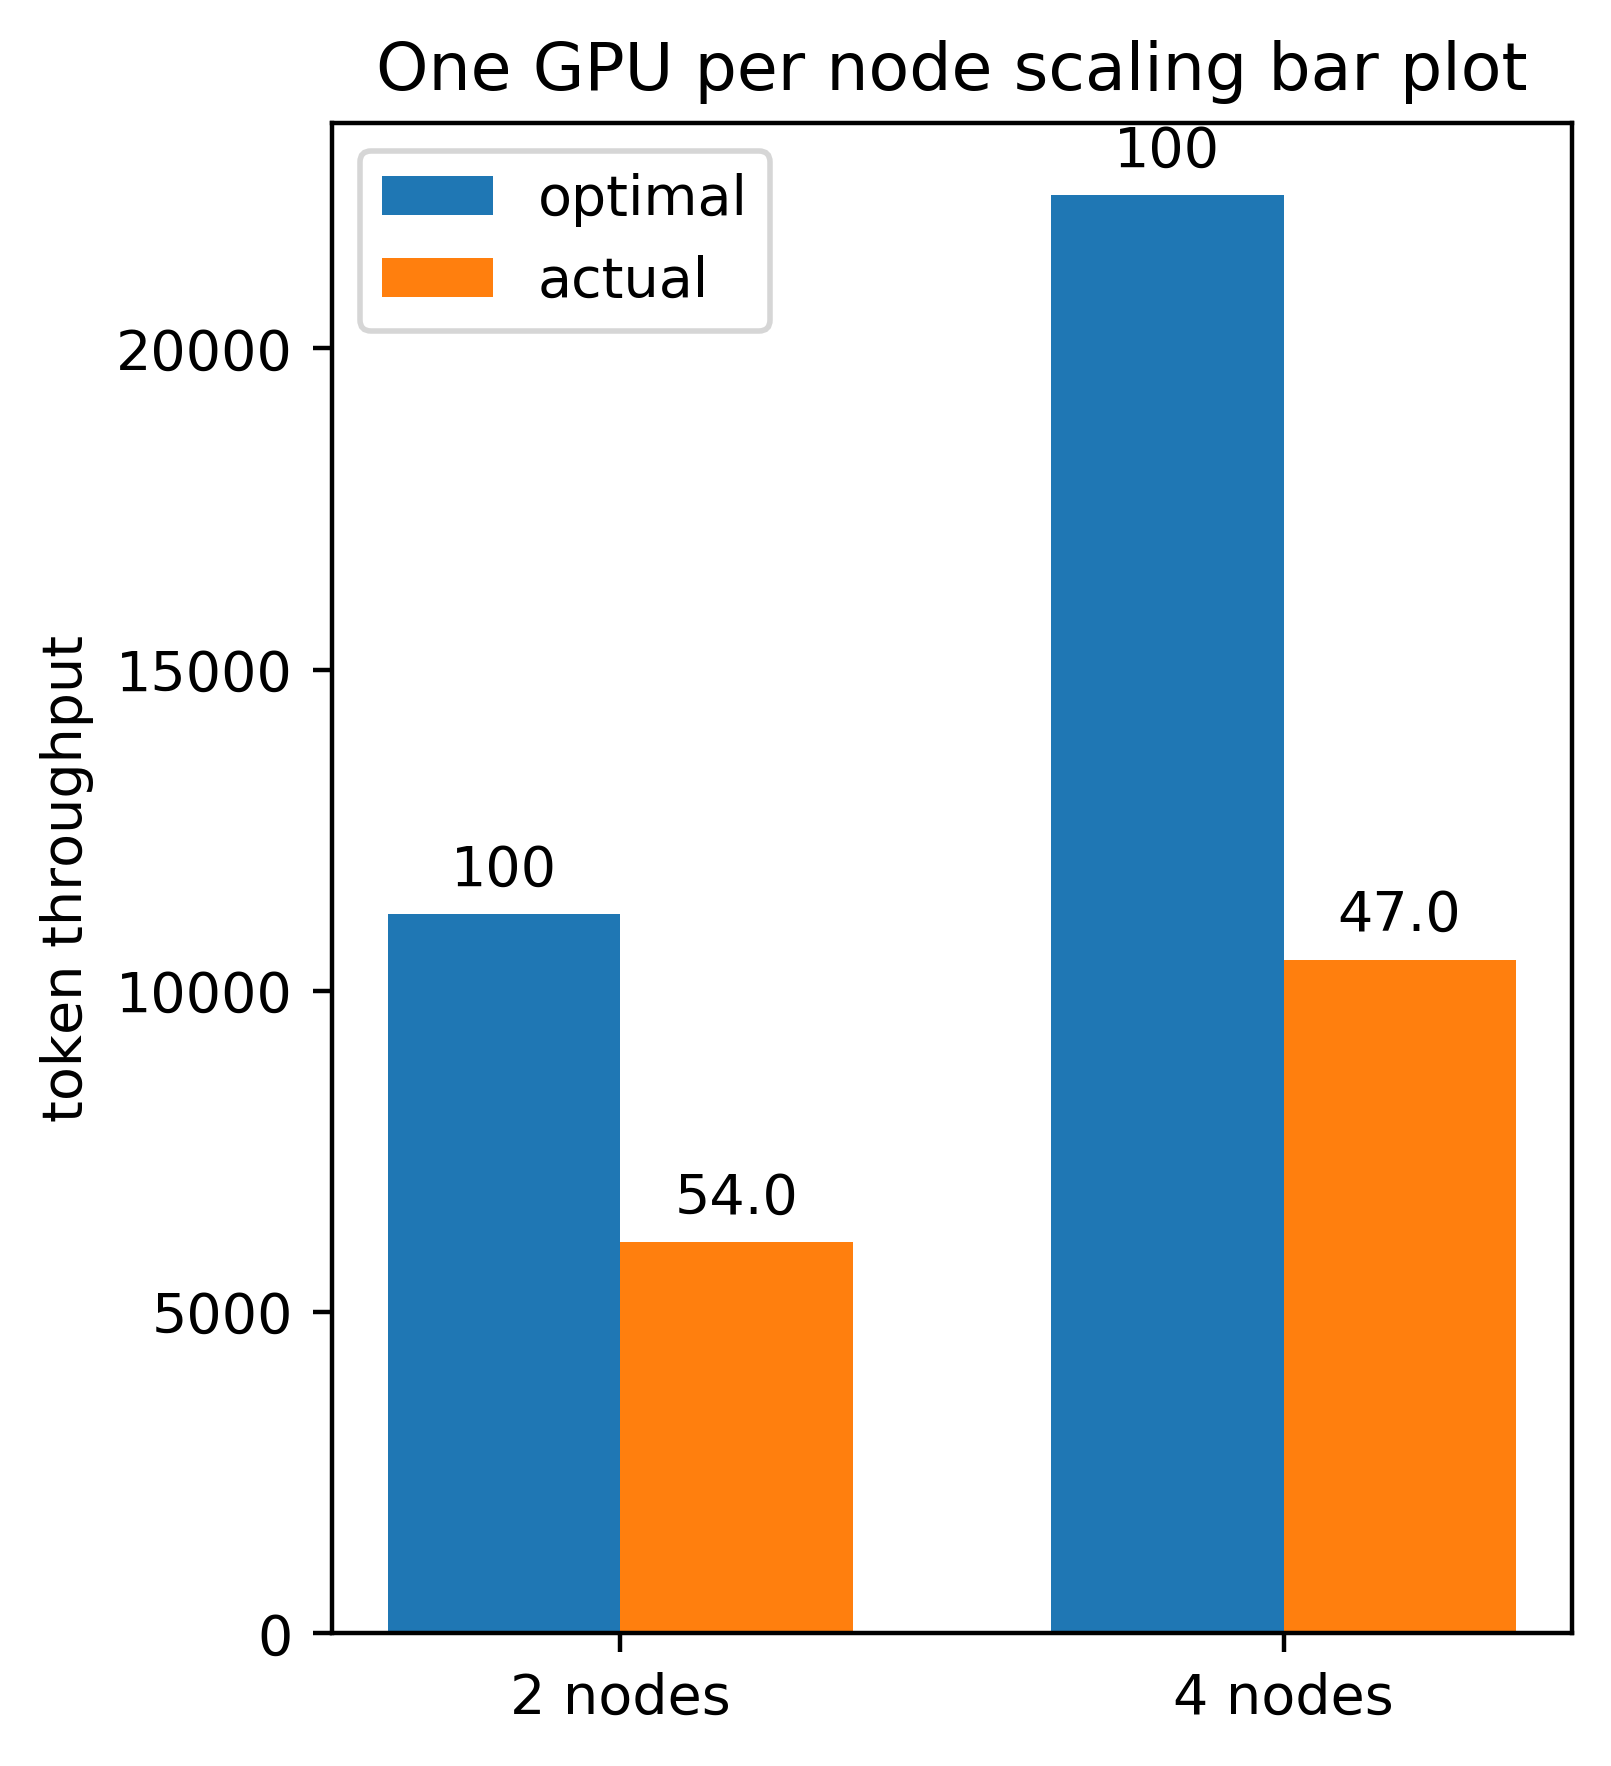

In [115]:
plot_scaling_up(df)

In [45]:
def plot_bar_overlay_comparison(df):
    width = 0.8
    df = df.sort_values('token_throughput')
    
    plt.figure(figsize=(8, 6), dpi=800, facecolor='w', edgecolor='k')
    
    bar1 = [1491.083485, 1491.083485, 1491.083485] # non-optimized
    
    bar2 = [4515.957600, 4515.957600] # fp16 + TensorCore
    
    bar3 = [5597.389597] # fp16 + TensorCore + Fused Kernel
    
    indices = 3
    
    plt.bar([1, 2, 3], bar1, width=0.4, fill=False, hatch='-', edgecolor='black', label='Non Optimized')
    
    plt.bar([2, 3], bar2, width=0.5, fill=False, hatch='.', edgecolor='blue', label="fp16 + TensorCore")
    
    plt.bar([3], bar3, width=0.6, fill=False, hatch='\\', edgecolor='green', label="fp16 + TensorCore + Kernel Fusion")
    
    plt.xticks([1, 2, 3])
    plt.ylabel("token throughput")
    plt.title("Single GPU (T4) optimization overlay bar plot")

    plt.legend()

    plt.show()

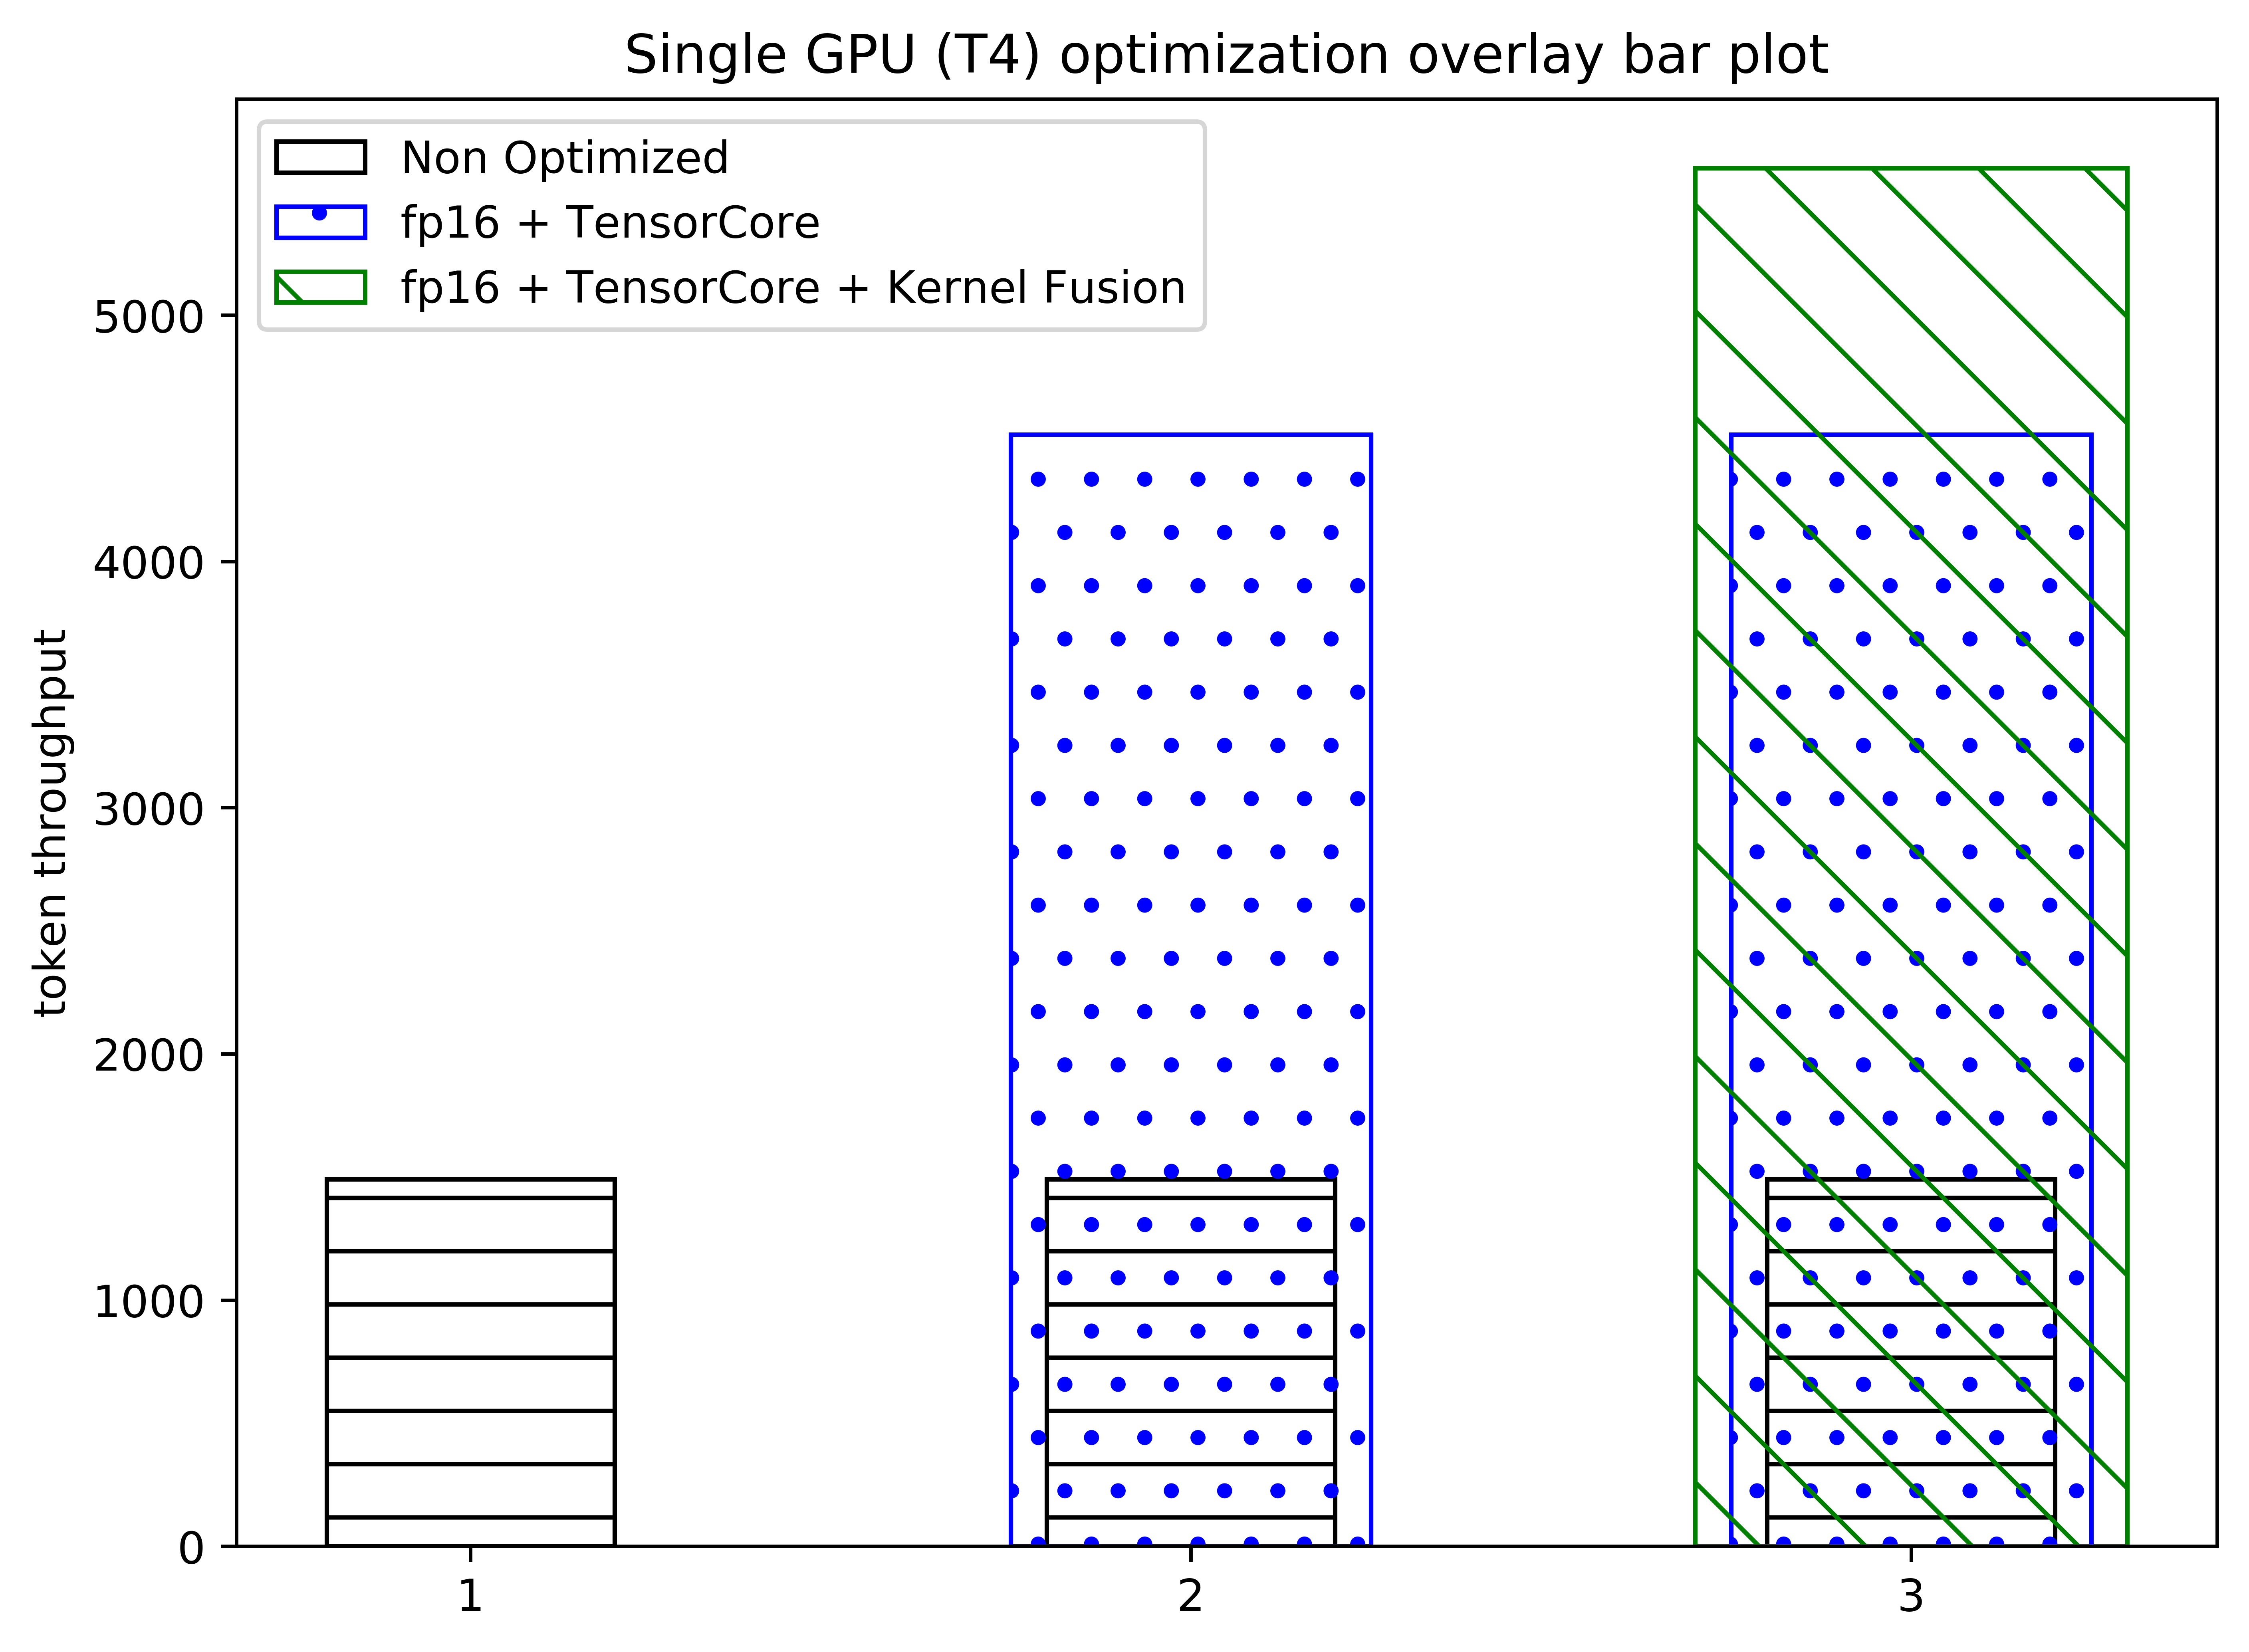

In [46]:
plot_bar_overlay_comparison(df)

In [220]:
def add_scaling_factor(df):
    gpu_1_baseline = df[df.num_gpus == 1]
    gpu_4_baseline = df[df.num_gpus == 4]
    
    def _add_scaling_factor(baseline_df,
                            batch_scale,
                            seq_len, 
                            batch_size, 
                            num_tokens, 
                            num_gpus,
                            gpu_type,
                            token_throughtput):
        single_gpu_batch_size = batch_size / num_gpus
        baseline_throughput = baseline_df[
            (baseline_df.gpu_type == gpu_type) &
            (baseline_df.seq_length == seq_len) &
            (baseline_df.batch_size / batch_scale == single_gpu_batch_size)
        ].token_throughput.values
        if len(baseline_throughput) == 1:
            return token_throughtput / baseline_throughput[0]
        else:
            return np.NaN
    
    df = add_column(
        df, output_col='scaling_factor_to_1_gpu', 
        input_cols=['seq_length', 'batch_size', 'num_tokens', 'num_gpus', 'gpu_type', 'token_throughput'],
        func=lambda *args: _add_scaling_factor(gpu_1_baseline, 1, *args)
    )
    
    df = add_column(
        df, output_col='scaling_factor_to_4_gpu', 
        input_cols=['seq_length', 'batch_size', 'num_tokens', 'num_gpus', 'gpu_type', 'token_throughput'],
        func=lambda *args: _add_scaling_factor(gpu_4_baseline, 4, *args)
    )
    
    return df

In [221]:
def add_scaling_efficacy(df):
    gpu_1_baseline = df[df.num_gpus == 1]
    gpu_4_baseline = df[df.num_gpus == 4]
    def _add_scaling_efficacy(baseline_df,
                              batch_scale,
                              seq_len, 
                              batch_size, 
                              num_tokens, 
                              num_gpus,
                              gpu_type,
                              token_throughtput):
        single_gpu_batch_size = batch_size / num_gpus
        efficacy_factor = num_gpus / batch_scale
        baseline_throughput = baseline_df[
            (baseline_df.gpu_type == gpu_type) &
            (baseline_df.seq_length == seq_len) &
            (baseline_df.batch_size / batch_scale == single_gpu_batch_size)
        ].token_throughput.values
        if len(baseline_throughput) == 1:
            return token_throughtput / (baseline_throughput[0] * efficacy_factor)
        else:
            return np.NaN
    
    df = add_column(
        df, output_col='scaling_efficacy_to_1_gpu', 
        input_cols=['seq_length', 'batch_size', 'num_tokens', 'num_gpus', 'gpu_type', 'token_throughput'],
        func=lambda *args: _add_scaling_efficacy(gpu_1_baseline, 1, *args)
    )
    
    df = add_column(
        df, output_col='scaling_efficacy_to_4_gpu', 
        input_cols=['seq_length', 'batch_size', 'num_tokens', 'num_gpus', 'gpu_type', 'token_throughput'],
        func=lambda *args: _add_scaling_efficacy(gpu_4_baseline, 4, *args)
    )
    
    return df

In [222]:
# df = df.drop(['scaling_factor'], axis=1)
df = add_scaling_factor(df)
df = add_scaling_efficacy(df)
df[df.num_gpus == 16] # t4

,seq_length,batch_size,num_tokens,elapsed_time,log_interval,compute_utilization,power_consumption,token_throughput,num_nodes,num_gpus,gpu_type,scaling_factor_to_1_gpu,scaling_factor_to_4_gpu,scaling_efficacy_to_1_gpu,scaling_efficacy_to_4_gpu
0,128.0,160.0,20480.0,173.041564,100.0,85.700,0.633707,11835.306821,4,16,t4,4.734001,1.679802,0.295875,0.419951
1,256.0,16.0,4096.0,153.150281,100.0,94.850,0.609771,2674.497207,4,16,t4,3.341266,1.375143,0.208829,0.343786
2,128.0,128.0,16384.0,167.612690,100.0,80.200,0.631975,9774.916235,4,16,t4,4.421127,1.612535,0.276320,0.403134
3,512.0,16.0,8192.0,158.931506,100.0,96.300,0.613464,5154.421679,4,16,t4,3.761570,1.478399,0.235098,0.369600
4,128.0,64.0,8192.0,156.694058,100.0,80.975,0.632850,5228.022126,4,16,t4,3.641627,1.441843,0.227602,0.360461
5,512.0,48.0,24576.0,189.227897,100.0,97.850,0.613704,12987.514215,4,16,t4,5.728847,1.861345,0.358053,0.465336
6,256.0,48.0,12288.0,163.723920,100.0,96.000,0.613436,7505.317468,4,16,t4,4.116114,1.540438,0.257257,0.385110
7,128.0,192.0,24576.0,180.633489,100.0,79.625,0.643064,13605.450520,4,16,t4,5.197328,1.779054,0.324833,0.444764
8,512.0,32.0,16384.0,173.634404,100.0,96.800,0.613904,9435.918036,4,16,t4,4.831502,1.686541,0.301969,0.421635
9,256.0,32.0,8192.0,157.168297,100.0,81.675,0.634804,5212.247108,4,16,t4,3.724082,1.454282,0.232755,0.363570


In [223]:
def plot_scaling_bar_plot(df, gpu_type, title):
    gpu_range = [1, 2, 4, 8, 16]
    def _get_max_throughput_rows(x):
        idx = x.groupby(['num_gpus', 'seq_length', 'gpu_type'], sort=False)['token_throughput'].transform(max) == x['token_throughput']
        return x[idx]
    
    df = df[df.gpu_type == gpu_type]
    baseline = _get_max_throughput_rows(df[df.num_gpus == 1])
    baseline = baseline[baseline.seq_length == 128]
    
    data = _get_max_throughput_rows(df)
    data = data[data.seq_length == 128]
    data = add_column(
        data, output_col='optimal_token_throughput',
        input_cols=['token_throughput', 'num_gpus'],
        func=lambda x, y: baseline.token_throughput.values[0] * y
    )
    data = data[data.num_gpus != 1]
    
    traces = [
        go.Bar(
            x=data.num_gpus.astype('category'), 
            y=data.token_throughput, 
            text=data.scaling_efficacy_to_1_gpu, 
            name="actual", 
        ),
        go.Bar(
            x=data.num_gpus.astype('category'), 
            y=data.optimal_token_throughput, 
            text=data.scaling_efficacy_to_1_gpu, 
            name="optimal (single gpu as baseline)", 
        ),
    ]
    
    layout = go.Layout(
        barmode = 'group',
        title = title,
        xaxis = dict(title = 'number of gpus'),
        yaxis = dict(title = 'token throughtput'),
    )
    fig = dict(data = traces, layout = layout)
    iplot(fig, filename=title)
    
    return data
     

In [224]:
plot_scaling_bar_plot(df, "t4", "BERT scaling efficacy plot")

,seq_length,batch_size,num_tokens,elapsed_time,log_interval,compute_utilization,power_consumption,token_throughput,num_nodes,num_gpus,gpu_type,scaling_factor_to_1_gpu,scaling_factor_to_4_gpu,scaling_efficacy_to_1_gpu,scaling_efficacy_to_4_gpu,optimal_token_throughput
0,128.0,256.0,32768.0,191.677634,100.0,97.800,0.612064,17095.369586,4,16,t4,5.884710,1.906962,0.367794,0.476740,46480.780275
2,128.0,128.0,16384.0,184.055073,100.0,80.525,0.643986,8901.683446,2,8,t4,3.064211,0.992969,0.383026,0.496484,23240.390138
3,128.0,32.0,4096.0,85.402670,100.0,79.650,0.637300,4796.102980,1,2,t4,1.650954,0.534998,0.825477,1.069996,5810.097534
4,128.0,64.0,8192.0,91.380477,100.0,78.825,0.638643,8964.715772,1,4,t4,3.085909,1.000000,0.771477,1.000000,11620.195069


In [40]:
t4_df = pd.read_csv('2_nodes_8_gpus_t4_benchmark.csv').drop(["Unnamed: 0", "iteration"], axis=1)
t4_df

,seq_length,batch_size,num_tokens,elapsed_time,log_interval,compute_utilization,power_consumption,token_throughput
0,128.0,8.0,1024.0,144.544079,100.0,75.100,0.636329,708.434414
1,128.0,112.0,14336.0,177.386475,100.0,84.075,0.634507,8081.788650
2,256.0,48.0,12288.0,174.690826,100.0,86.550,0.633946,7034.141556
3,256.0,56.0,14336.0,181.707363,100.0,80.425,0.642725,7889.608759
4,256.0,32.0,8192.0,161.191925,100.0,81.275,0.628500,5082.140437
5,128.0,128.0,16384.0,184.055073,100.0,80.525,0.643986,8901.683446
6,256.0,40.0,10240.0,167.703564,100.0,80.600,0.643925,6106.012140
7,128.0,16.0,2048.0,144.687101,100.0,83.550,0.634957,1415.468271
8,256.0,24.0,6144.0,155.710427,100.0,81.025,0.639443,3945.785846
9,128.0,32.0,4096.0,148.797205,100.0,85.100,0.635896,2752.739882


In [41]:
p100_df = pd.read_csv('1_nodes_4_gpus_p100_benchmark.csv').drop(["Unnamed: 0", "iteration"], axis=1)
p100_df

,seq_length,batch_size,num_tokens,elapsed_time,log_interval,compute_utilization,power_consumption,token_throughput
0,512.0,4.0,2048.0,58.633919,100.0,79.025,0.175075,3492.858788
1,256.0,4.0,1024.0,49.591473,100.0,72.225,0.170067,2064.871094
2,128.0,32.0,4096.0,72.168520,100.0,77.875,0.177618,5675.604851
3,128.0,48.0,6144.0,97.401109,100.0,78.350,0.175673,6307.936362
4,256.0,12.0,3072.0,65.502281,100.0,76.950,0.173352,4689.912990
5,128.0,16.0,2048.0,56.289425,100.0,76.650,0.174244,3638.338807
6,256.0,8.0,2048.0,57.082060,100.0,79.025,0.170477,3587.817285
7,128.0,40.0,5120.0,79.934179,100.0,82.150,0.171316,6405.269982
8,512.0,8.0,4096.0,86.624035,100.0,82.450,0.171180,4728.479780
9,256.0,16.0,4096.0,73.780055,100.0,77.600,0.177648,5551.635837


In [42]:
def plot_throughput(df, title):
    seq_lens = df["seq_length"].unique()
    traces, sub_titles = [], []
    for s in seq_lens:
        traces.append(go.Scatter(
            x=df[df["seq_length"] == s].sort_values('num_tokens')["num_tokens"],
            y=df[df["seq_length"] == s].sort_values('num_tokens')["token_throughput"],
            mode='lines+markers',
            name="sequence length {}".format(s)
        ))
        sub_titles.append("sequence length {} throughput".format(s))

    layout = dict(title = title,
              xaxis = dict(title = 'number of tokens'),
              yaxis = dict(title = 'token throughtput'),
            )

    fig = dict(data=traces, layout=layout)
    iplot(fig, filename=title)

In [50]:
plot_throughput(t4_df, "BERT on t4 throughput plot")

In [51]:
plot_throughput(p100_df, "BERT on p100 throughput plot")

In [11]:
grad_df = pd.read_csv('huggingface_gradient_size_profile.csv').drop(["Unnamed: 0"], axis=1)
grad_df

,param_name,dtype,size
0,bert.embeddings.word_embeddings.weight,torch.float16,"torch.Size([30522, 1024])"
1,bert.embeddings.position_embeddings.weight,torch.float16,"torch.Size([512, 1024])"
2,bert.embeddings.token_type_embeddings.weight,torch.float16,"torch.Size([2, 1024])"
3,bert.embeddings.LayerNorm.weight,torch.float16,torch.Size([1024])
4,bert.embeddings.LayerNorm.bias,torch.float16,torch.Size([1024])
5,bert.encoder.layer.0.attention.self.query.weight,torch.float16,"torch.Size([1024, 1024])"
6,bert.encoder.layer.0.attention.self.query.bias,torch.float16,torch.Size([1024])
7,bert.encoder.layer.0.attention.self.key.weight,torch.float16,"torch.Size([1024, 1024])"
8,bert.encoder.layer.0.attention.self.key.bias,torch.float16,torch.Size([1024])
9,bert.encoder.layer.0.attention.self.value.weight,torch.float16,"torch.Size([1024, 1024])"


In [12]:
def add_grad_size(df):
    from functools import reduce # Valid in Python 2.6+, required in Python 3
    from operator import mul
    
    def _add_grad_size(dtype, size):
        bytes_per_entry = int(dtype.split("torch.float")[-1]) / 8
        dims = eval(size.split("torch.Size")[-1])
        num_entrys = reduce(mul, dims, 1)
        return int(num_entrys * bytes_per_entry / 1024)
    
    df = add_column(
        df, output_col='gradient_size_kb', 
        input_cols=['dtype', 'size'],
        func=lambda dtype, size: _add_grad_size(dtype, size)
    )
    return df

In [13]:
grad_df = add_grad_size(grad_df)
grad_df

,param_name,dtype,size,gradient_size_kb
0,bert.embeddings.word_embeddings.weight,torch.float16,"torch.Size([30522, 1024])",61044
1,bert.embeddings.position_embeddings.weight,torch.float16,"torch.Size([512, 1024])",1024
2,bert.embeddings.token_type_embeddings.weight,torch.float16,"torch.Size([2, 1024])",4
3,bert.embeddings.LayerNorm.weight,torch.float16,torch.Size([1024]),2
4,bert.embeddings.LayerNorm.bias,torch.float16,torch.Size([1024]),2
5,bert.encoder.layer.0.attention.self.query.weight,torch.float16,"torch.Size([1024, 1024])",2048
6,bert.encoder.layer.0.attention.self.query.bias,torch.float16,torch.Size([1024]),2
7,bert.encoder.layer.0.attention.self.key.weight,torch.float16,"torch.Size([1024, 1024])",2048
8,bert.encoder.layer.0.attention.self.key.bias,torch.float16,torch.Size([1024]),2
9,bert.encoder.layer.0.attention.self.value.weight,torch.float16,"torch.Size([1024, 1024])",2048


In [74]:
def bar_pie_plot(df):
    break_down = {
        "embeddings": 0,
        "dense": 0,
        "others": 0
    }
    
    for _, row in df.iterrows():
        if "embeddings" in row['param_name']:
            break_down["embeddings"] += row["gradient_size_kb"]
        elif "dense" in row['param_name']:
            break_down["dense"] += row["gradient_size_kb"]
        else:
            break_down["others"] += row["gradient_size_kb"]
    
    total = df["gradient_size_kb"].sum()
    print("total size of gradients is {}".format(total / 1024))
    
    print(break_down)
    labels, values = list(zip(*break_down.items()))
    values = [ round(x / 1024, 2) for x in values ]
    fig = go.Figure(
        data=[go.Pie(labels=labels, values=values)],
        layout={"title": "BERT FP16 Gradient Break Down (MB)"}
    )
    fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=18)
    fig.show()

In [75]:
bar_pie_plot(grad_df)

total size of gradients is 641.2998046875
{'embeddings': 62076, 'dense': 446756, 'others': 147859}


In [19]:
grad_df = grad_df.sort_values(by='gradient_size_kb', ascending=False)
grad_df

,param_name,dtype,size,gradient_size_kb
0,bert.embeddings.word_embeddings.weight,torch.float16,"torch.Size([30522, 1024])",61044
63,bert.encoder.layer.3.intermediate.dense.weight,torch.float16,"torch.Size([4096, 1024])",8192
209,bert.encoder.layer.12.output.dense.weight,torch.float16,"torch.Size([1024, 4096])",8192
223,bert.encoder.layer.13.intermediate.dense.weight,torch.float16,"torch.Size([4096, 1024])",8192
225,bert.encoder.layer.13.output.dense.weight,torch.float16,"torch.Size([1024, 4096])",8192
239,bert.encoder.layer.14.intermediate.dense.weight,torch.float16,"torch.Size([4096, 1024])",8192
241,bert.encoder.layer.14.output.dense.weight,torch.float16,"torch.Size([1024, 4096])",8192
65,bert.encoder.layer.3.output.dense.weight,torch.float16,"torch.Size([1024, 4096])",8192
255,bert.encoder.layer.15.intermediate.dense.weight,torch.float16,"torch.Size([4096, 1024])",8192
305,bert.encoder.layer.18.output.dense.weight,torch.float16,"torch.Size([1024, 4096])",8192


In [10]:
"bert.encoder.layer.3.intermediate.dense.weight".split("bert.encoder.layer.")

['', '3.intermediate.dense.weight']

In [20]:
"dense" in "bert.encoder.layer.3.intermediate.dense.weight"

True

In [27]:
break_down = {
        "embeddings": 0,
        "dense": 0,
        "others": 0
}
list(zip(*break_down.items()))

[('embeddings', 'dense', 'others'), (0, 0, 0)]